# Analysis of domain for plasticity rule

In [82]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)

from network import run_network_recall, train_network, run_network_recall_limit
from connectivity import designed_matrix_sequences, designed_matrix_sequences_local
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence, create_sequence_chain
from analysis import time_t1, time_t2, time_t1_local, time_t2_local, time_t2_complicated
from network import run_network_recall_limit_end

## Study of the data

In [83]:
from sklearn.model_selection import train_test_split
import sklearn.linear_model as linear_model

N = 10
tau_z = 0.150
tau_z_post = 0.005
tau_w = 0.100
max_w = 30.0
min_w = -3.0

training_time = 0.100
inter_sequence_time = 1.000
dt = 0.001
epochs = 4
sequence1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
sequences = [sequence1]

pattern = 3
pattern_from = 2

saved_matrix = True
outfile = '../data_analysis_of_domain.npz'
if not saved_matrix:
    n_samples = 10000
    max_w_vector = np.random.uniform(low=1, high=200, size=n_samples)
    min_w_vector = -np.random.uniform(low=1, high=100, size=n_samples)
    tau_z_vector = np.random.uniform(low=0.050, high=1.050, size=n_samples)

    X = np.zeros((n_samples, 3))
    y = np.zeros((n_samples, 3))

    for index, (tau_z, max_w, min_w) in enumerate(zip(tau_z_vector, max_w_vector, min_w_vector)):
        dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z, tau_z_post,
                        tau_w, epochs=epochs, max_w=max_w, min_w=min_w, save_w_history=True, pre_rule=True)


        w = dic['w']
        self = w[pattern, pattern]
        exc = w[pattern, pattern_from]
        inh = w[pattern_from, pattern]

        y[index, 0] = self
        y[index, 1] = exc
        y[index, 2] = inh

        X[index, 0] = tau_z
        X[index, 1] = max_w
        X[index, 2] = min_w

    # Now we save both X and Y
    np.savez(outfile, x=X, y=y)
else:
    npz_file = np.load(outfile)
    X = npz_file['x']
    y = npz_file['y']

The classifier

In [84]:
# Here we do the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

reg = linear_model.LinearRegression(fit_intercept=False, n_jobs=-1)
reg.fit(X_train, y_train)
score = reg.score(X_test, y_test)
A = reg.coef_
B = np.linalg.inv(A)
print('score', score)

score 0.907007667226


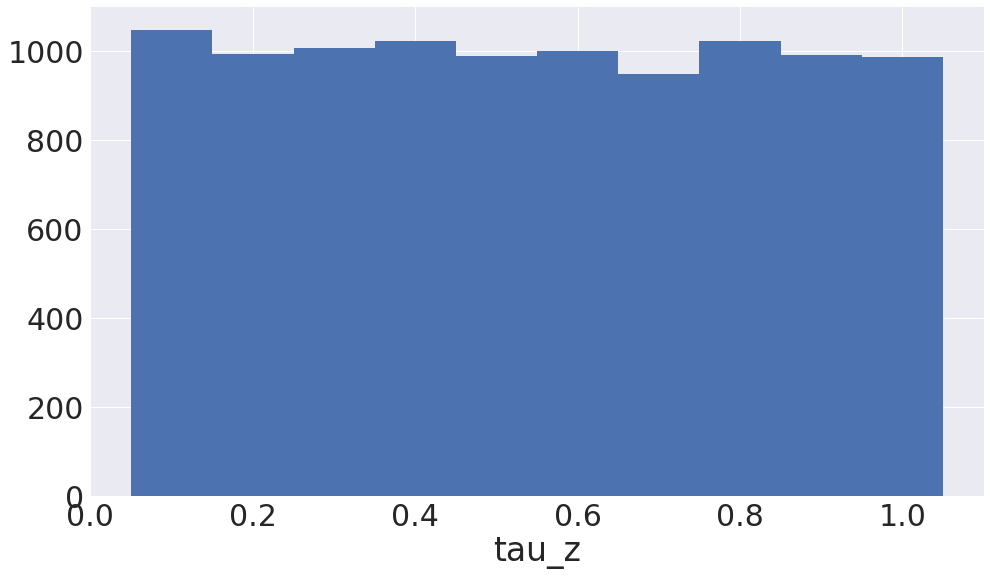

In [85]:
plt.hist(X[:, 0])
plt.xlabel('tau_z');

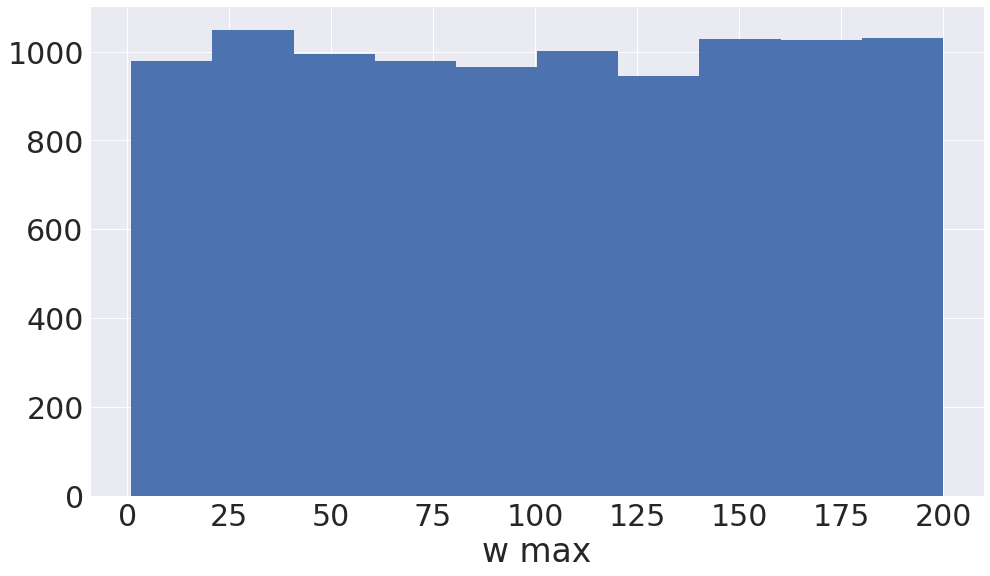

In [58]:
plt.hist(X[:, 1])
plt.xlabel('w max');

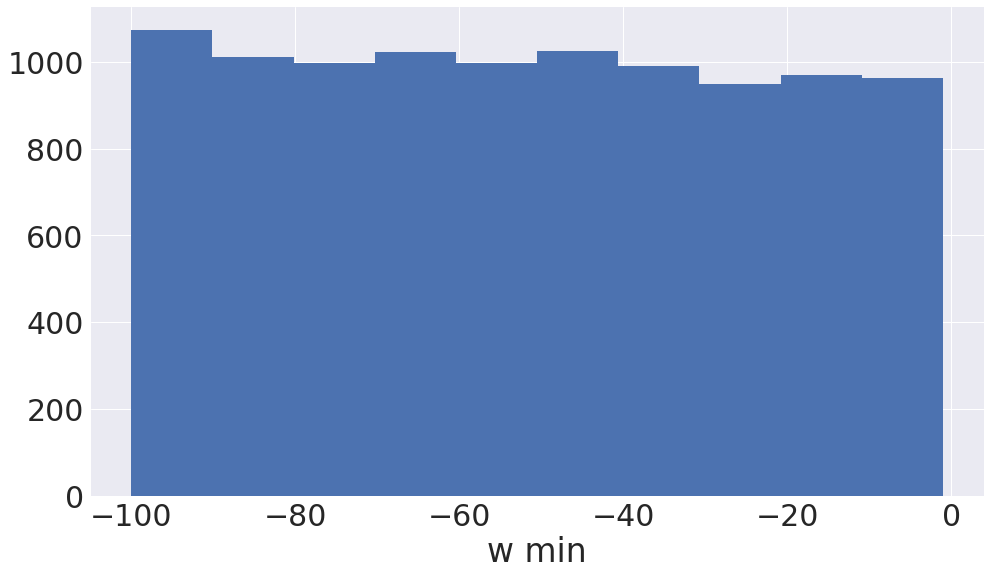

In [60]:
plt.hist(X[:, 2])
plt.xlabel('w min');

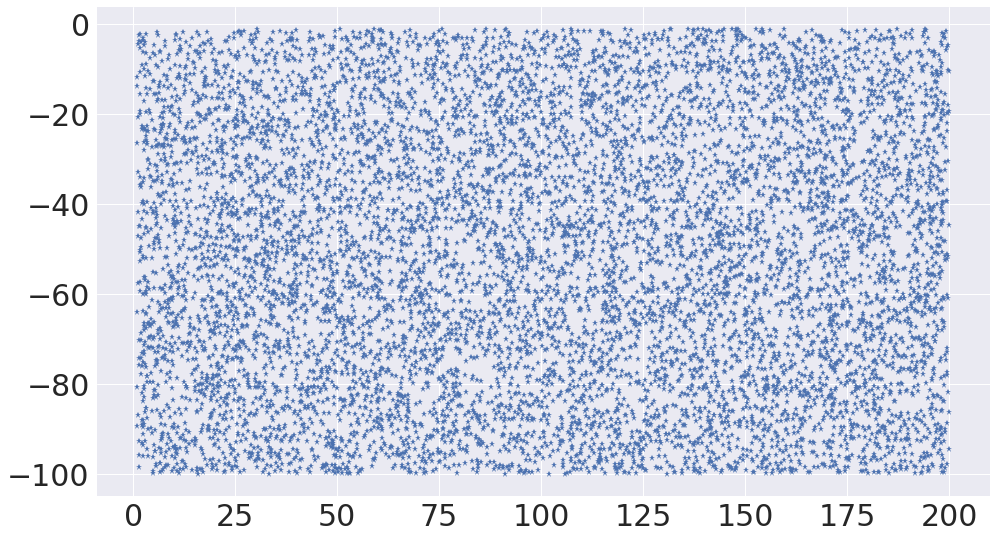

In [62]:
plt.plot(X[:, 1], X[:, 2], '*')

In [7]:
# I want to calculate the values for which the self-excitation and the transition are positive
positive_A = y[:, 0] > 0
positive_T = y[:, 1] > 0
negative_I = y[:, 2] < 0

# Now the values that generated the valures in the correct domain are
domain_indexes = positive_A * positive_T * negative_I
X_right = X[domain_indexes, : ]
y_right = y[domain_indexes, :]

print('number of right examples', domain_indexes.sum())

number of right examples 1065


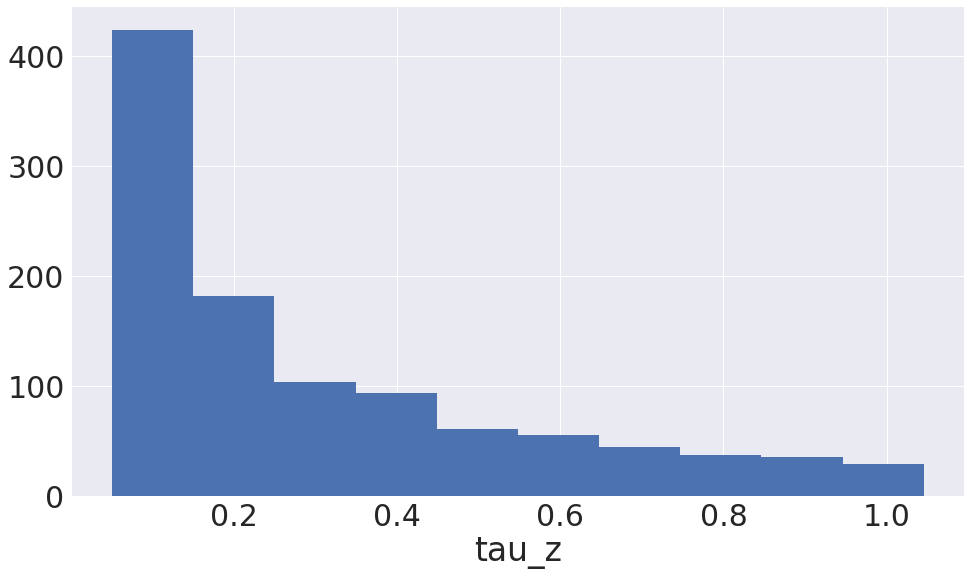

In [8]:
plt.hist(X_right[:, 0])
plt.xlabel('tau_z');

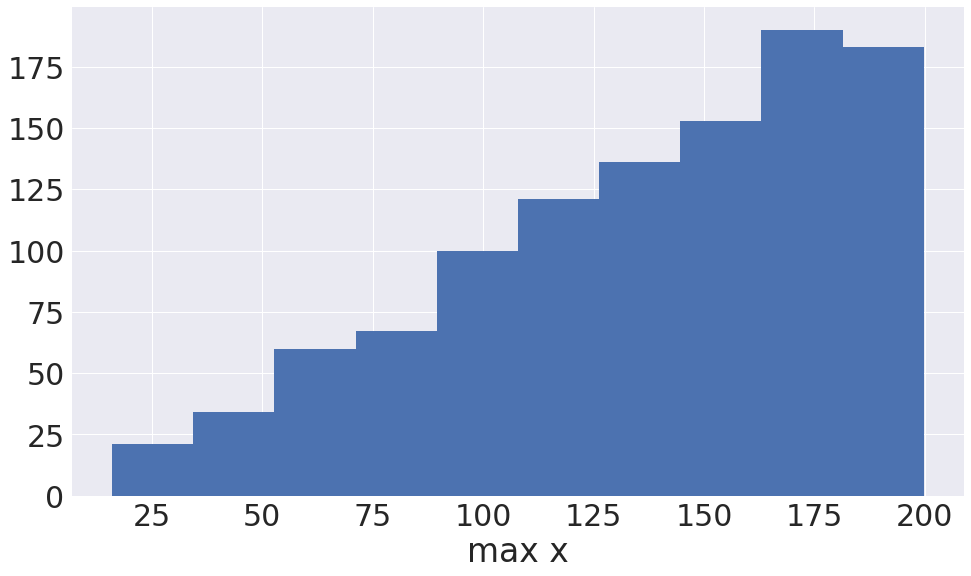

In [9]:
plt.hist(X_right[:, 1])
plt.xlabel('max w');

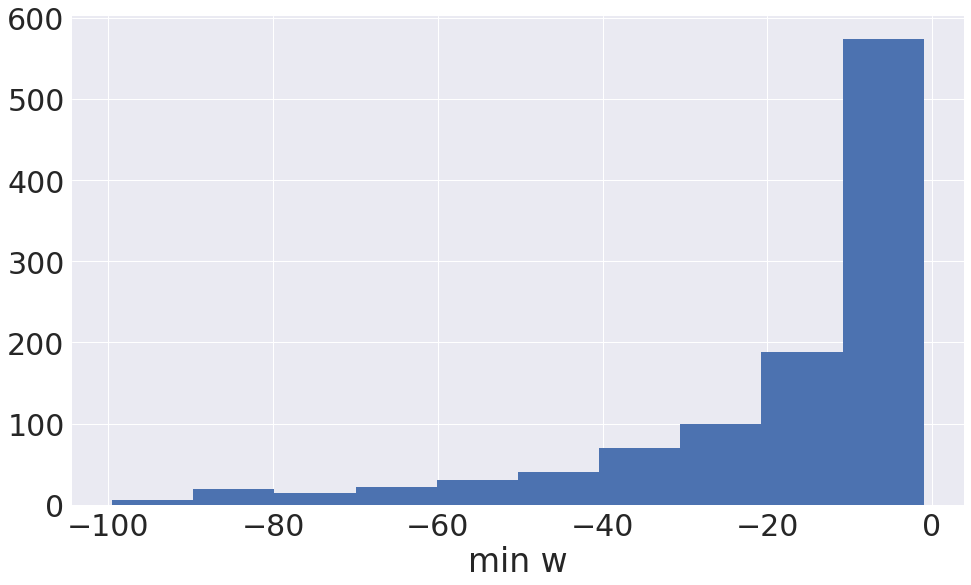

In [10]:
plt.hist(X_right[:, 2])
plt.xlabel('min w');

We can appreciate that the space that for tau_z becomes smaller the bigger is tau_z, also we need a big max_w we see that min_w is constrained as well

Let's see how the A, T and I faire on this domain

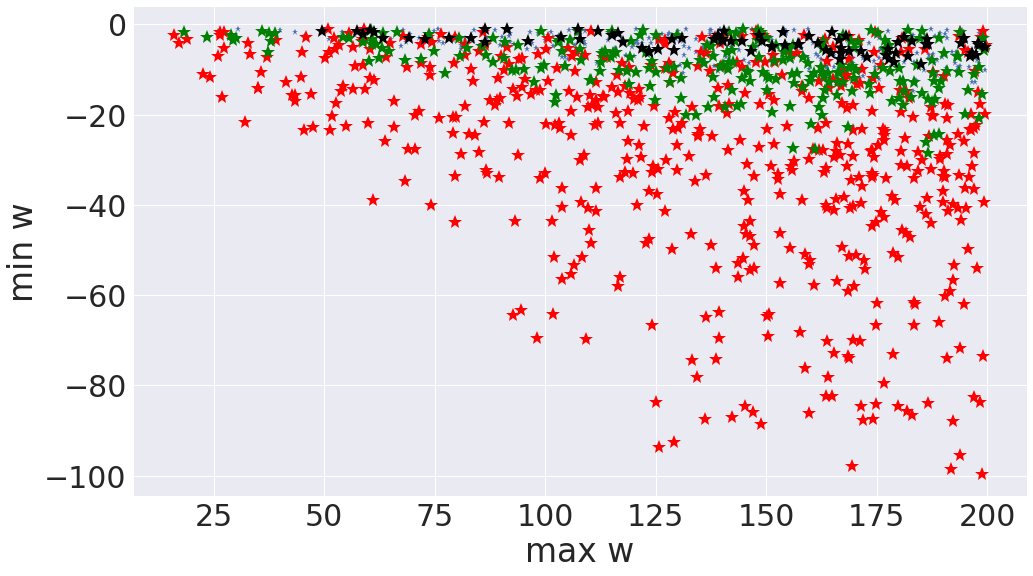

In [75]:
plt.plot(X_right[:, 1], X_right[:, 2], '*')
plt.xlabel('max_w')
plt.ylabel('min w')

markersize = 15

tau_z_threshold = 0.200
tau_z_threshold_indexes = X_right[:, 0] < tau_z_threshold
plt.plot(X_right[tau_z_threshold_indexes, 1], X_right[tau_z_threshold_indexes, 2], '*', markersize=markersize, color='red')
plt.xlabel('max w')
plt.ylabel('min w')

tau_z_threshold = 0.200
tau_z_threshold_2 = 0.400
tau_z_threshold_indexes_1 = X_right[:, 0] < tau_z_threshold_2 
tau_z_threshold_indexes_2 = X_right[:, 0] > tau_z_threshold
tau_z_threshold_indexes = tau_z_threshold_indexes_1 * tau_z_threshold_indexes_2

plt.plot(X_right[tau_z_threshold_indexes, 1], X_right[tau_z_threshold_indexes, 2], '*', markersize=markersize, color='green')
plt.xlabel('max w')
plt.ylabel('min w')

tau_z_threshold = 0.800
tau_z_threshold_indexes = X_right[:, 0]  > tau_z_threshold
plt.plot(X_right[tau_z_threshold_indexes, 1], X_right[tau_z_threshold_indexes, 2], '*', markersize=markersize, color='black')
plt.xlabel('max w')
plt.ylabel('min w')

#### Sub-domain with tau_z

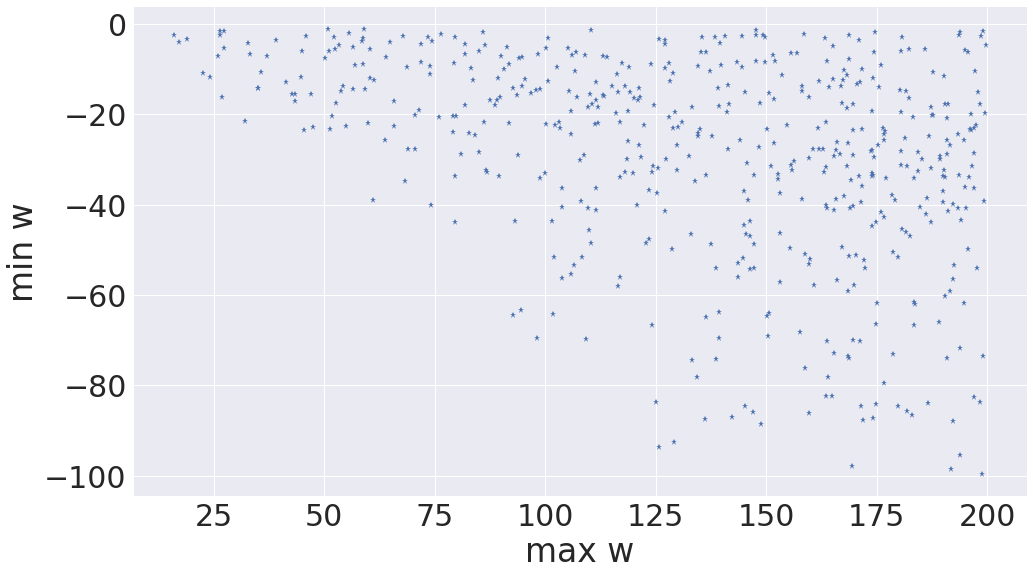

In [68]:
tau_z_threshold = 0.200
tau_z_threshold_indexes = X_right[:, 0] < tau_z_threshold
plt.plot(X_right[tau_z_threshold_indexes, 1], X_right[tau_z_threshold_indexes, 2], '*')
plt.xlabel('max w')
plt.ylabel('min w')


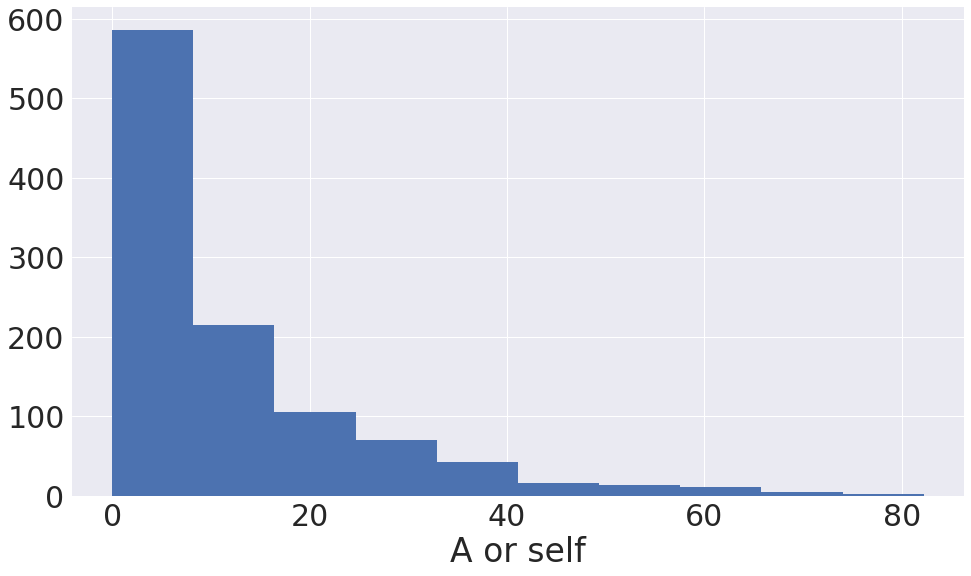

In [11]:
plt.hist(y_right[:, 0])
plt.xlabel('A or self');

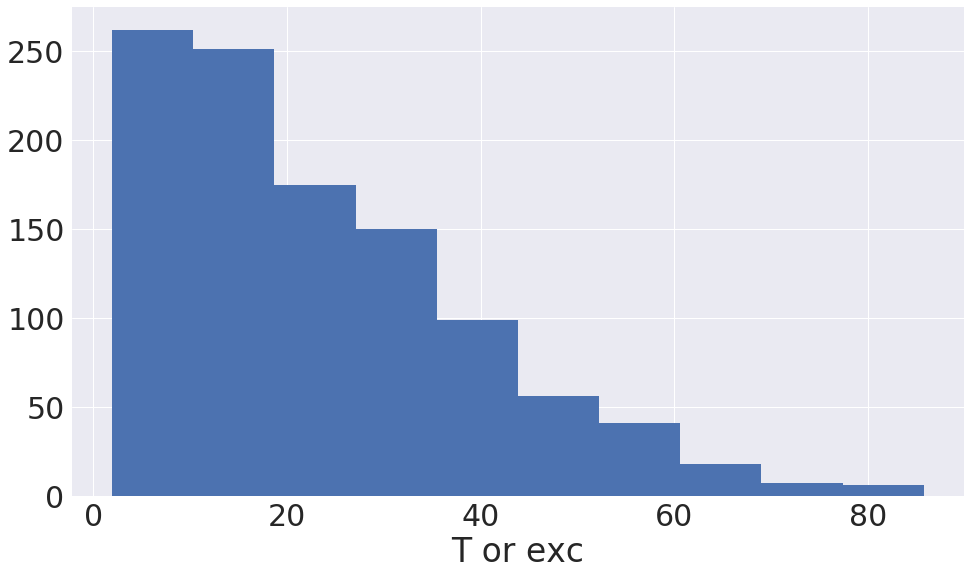

In [12]:
plt.hist(y_right[:, 1])
plt.xlabel('T or exc');

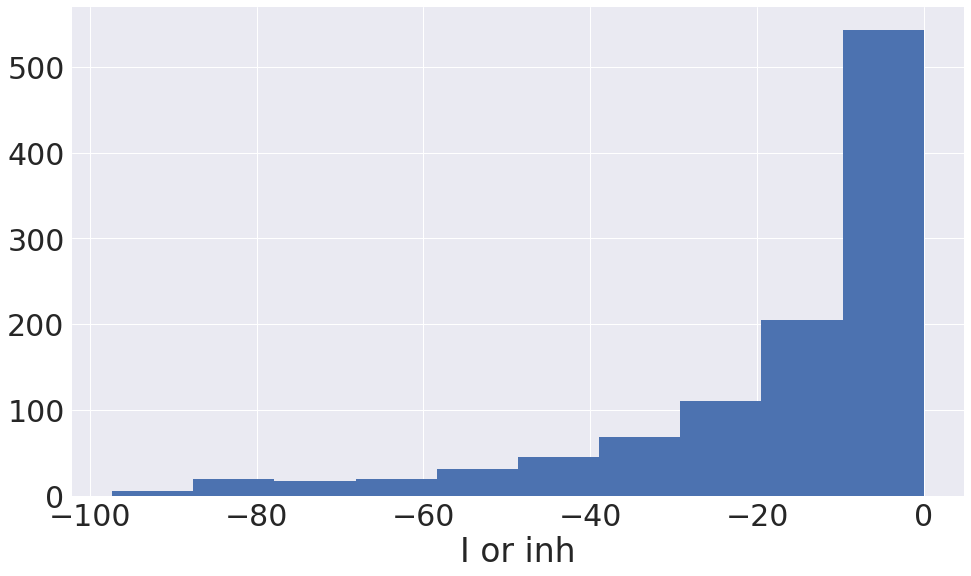

In [13]:
plt.hist(y_right[:, 2])
plt.xlabel('I or inh');

It is important to consider only the values where I > A so the network can move forward to get the right values

In [14]:
sequence_indexes = y_right[:, 0] < (-1) * y_right[:, 2]
print('sequence indexes correct', sequence_indexes.sum())

sequence indexes correct 643


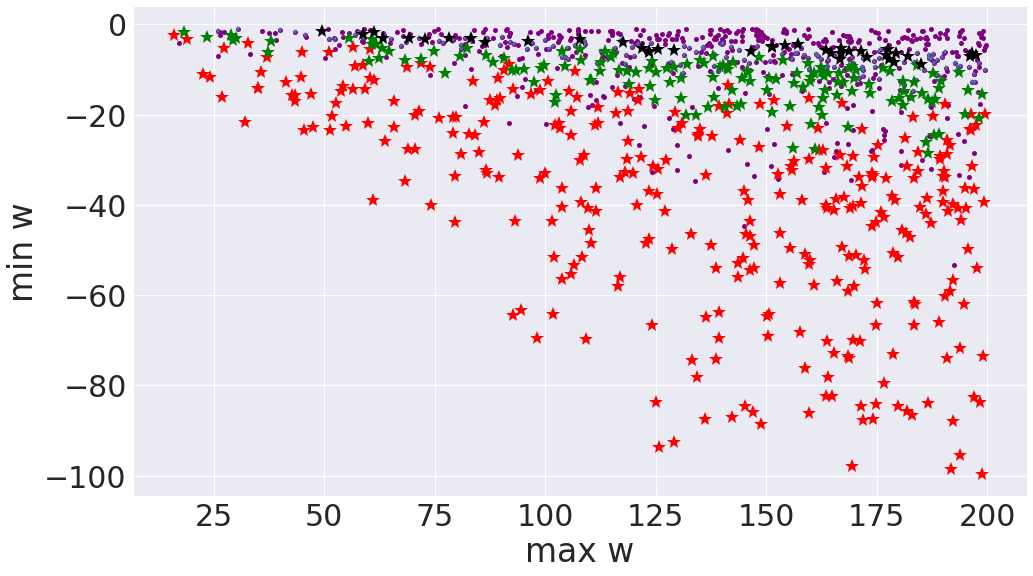

In [81]:
X_second_condition = X_right[sequence_indexes, :]

plt.plot(X_right[:, 1], X_right[:, 2], 'o', markersize=5, color='purple')

A = X_second_condition

plt.plot(A[:, 1], A[:, 2], '*')
plt.xlabel('max_w')
plt.ylabel('min w')

markersize = 15

tau_z_threshold = 0.200
tau_z_threshold_indexes = A[:, 0] < tau_z_threshold
plt.plot(A[tau_z_threshold_indexes, 1], A[tau_z_threshold_indexes, 2], '*', markersize=markersize, color='red')
plt.xlabel('max w')
plt.ylabel('min w')

tau_z_threshold = 0.200
tau_z_threshold_2 = 0.400
tau_z_threshold_indexes_1 = A[:, 0] < tau_z_threshold_2 
tau_z_threshold_indexes_2 = A[:, 0] > tau_z_threshold
tau_z_threshold_indexes = tau_z_threshold_indexes_1 * tau_z_threshold_indexes_2

plt.plot(A[tau_z_threshold_indexes, 1], A[tau_z_threshold_indexes, 2], '*', markersize=markersize, color='green')
plt.xlabel('max w')
plt.ylabel('min w')

tau_z_threshold = 0.800
tau_z_threshold_indexes = A[:, 0]  > tau_z_threshold
plt.plot(A[tau_z_threshold_indexes, 1], A[tau_z_threshold_indexes, 2], '*', markersize=markersize, color='black')
plt.xlabel('max w')
plt.ylabel('min w')



Let's revisit the values above with this values for X_right and y_right

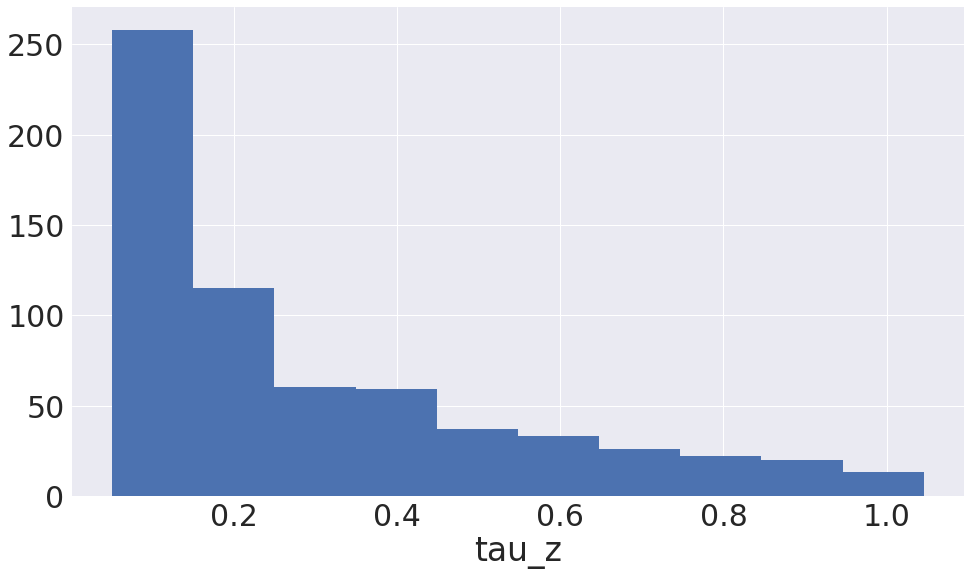

In [15]:
plt.hist(X_right[sequence_indexes, 0])
plt.xlabel('tau_z');

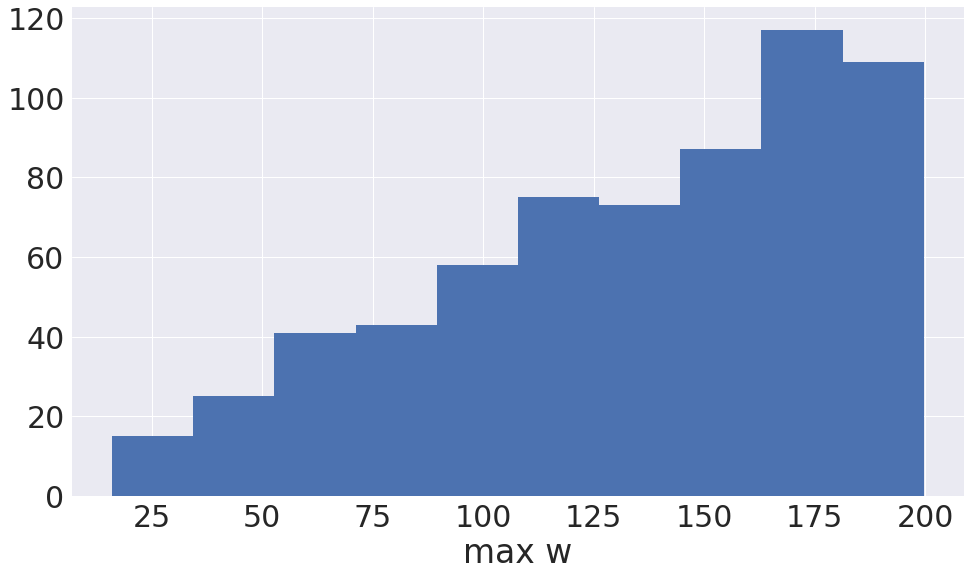

In [16]:
plt.hist(X_right[sequence_indexes, 1])
plt.xlabel('max w');

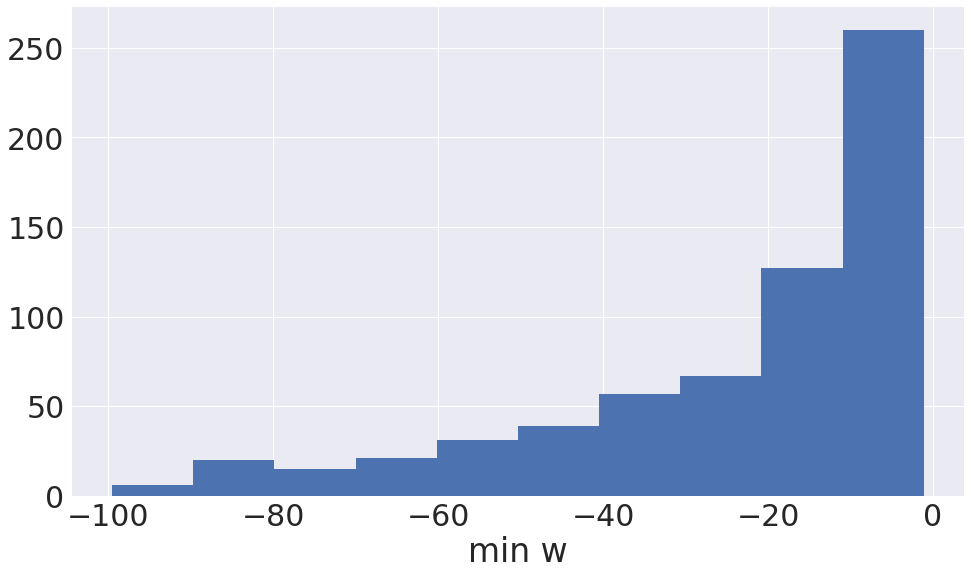

In [17]:
plt.hist(X_right[sequence_indexes, 2])
plt.xlabel('min w');

Let's restrain ourselves to values of tau_z bigger than 0.300 and smaller than 0.500

In [18]:
lower_right = X_right[:, 0] > 0.300
upper_right = X_right[:, 0] < 0.550

In [19]:
right_big_tau_z = lower_right * upper_right * sequence_indexes
print('big z domain', right_big_tau_z.sum())

big z domain 128


In [20]:
X_big_tau = X_right[right_big_tau_z, :]
y_big_tau = y_right[right_big_tau_z, :]

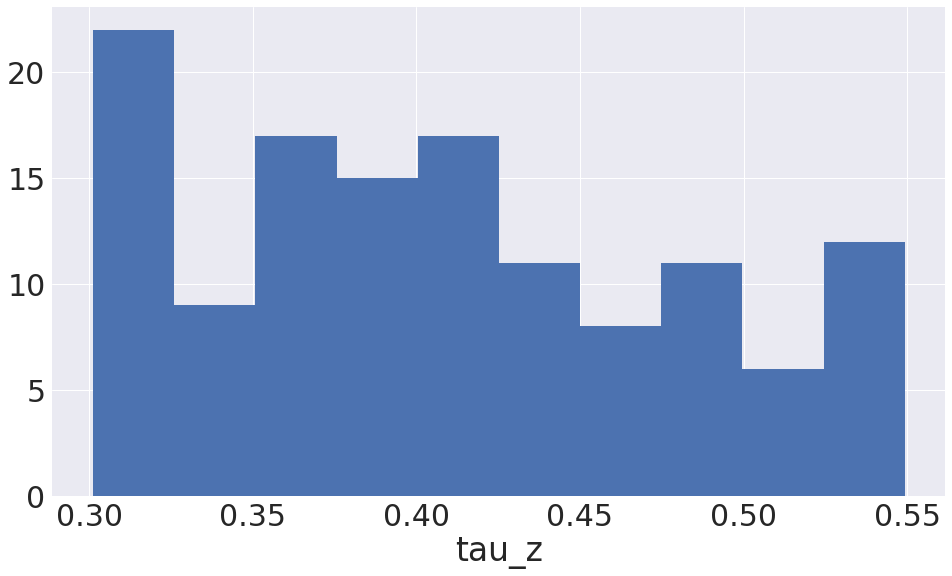

In [21]:
plt.hist(X_big_tau[:, 0])
plt.xlabel('tau_z')

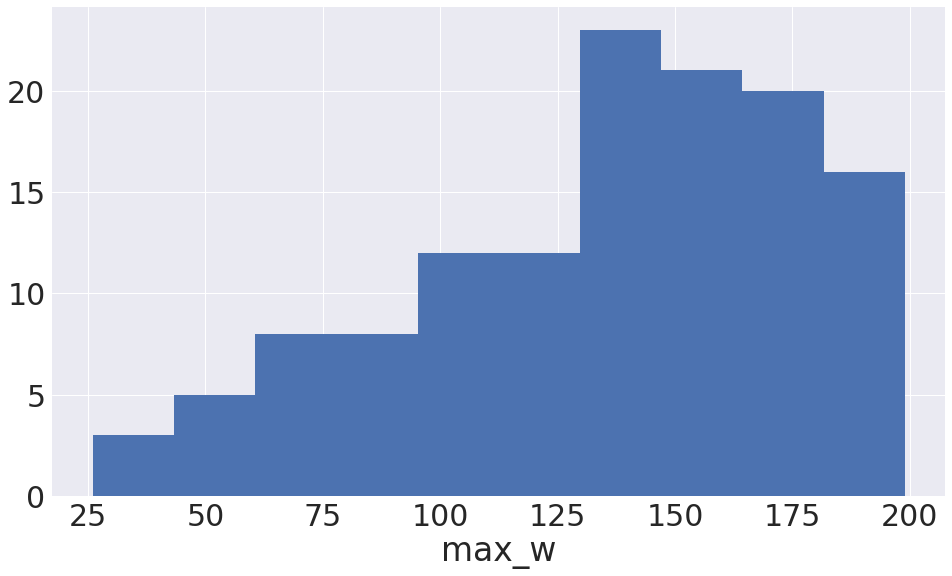

In [22]:
plt.hist(X_big_tau[:, 1])
plt.xlabel('max_w')

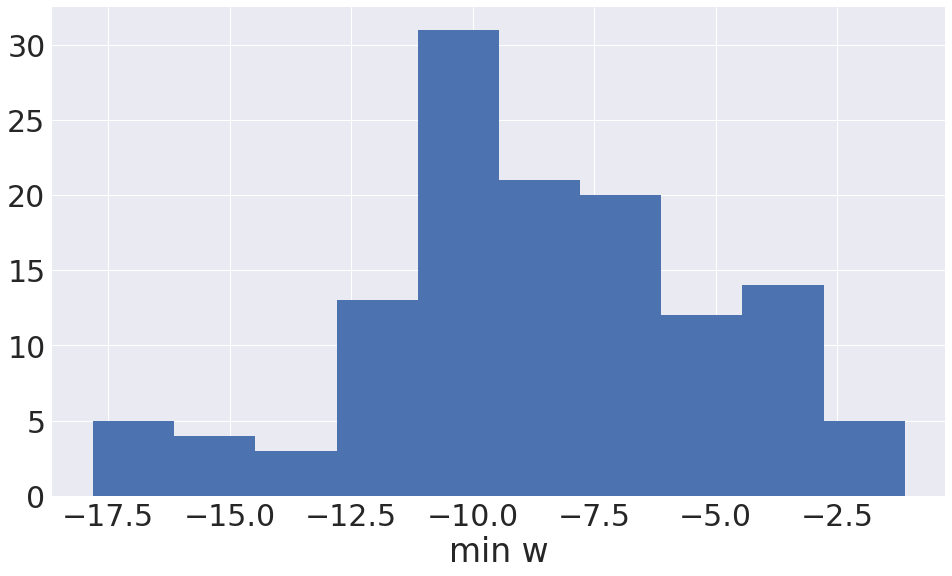

In [23]:
plt.hist(X_big_tau[:, 2])
plt.xlabel('min w')

Let's see what values of A, T, and we do encounter for this domain

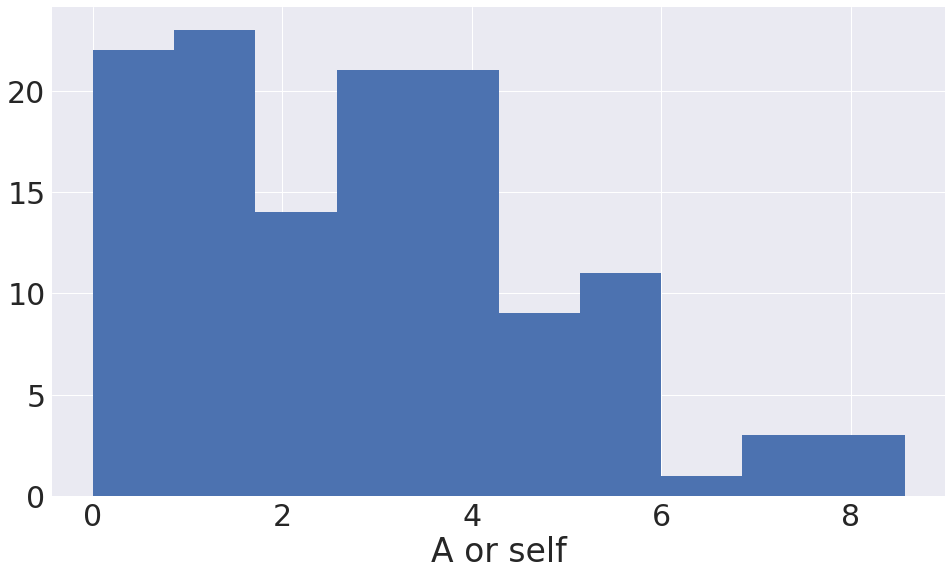

In [24]:
plt.hist(y_big_tau[:, 0])
plt.xlabel('A or self')

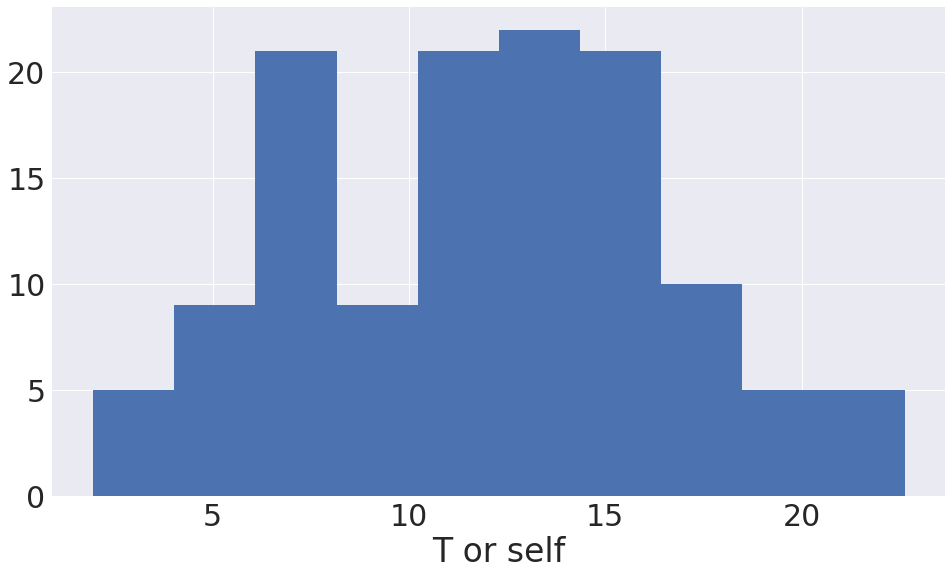

In [25]:
plt.hist(y_big_tau[:, 1])
plt.xlabel('T or self')

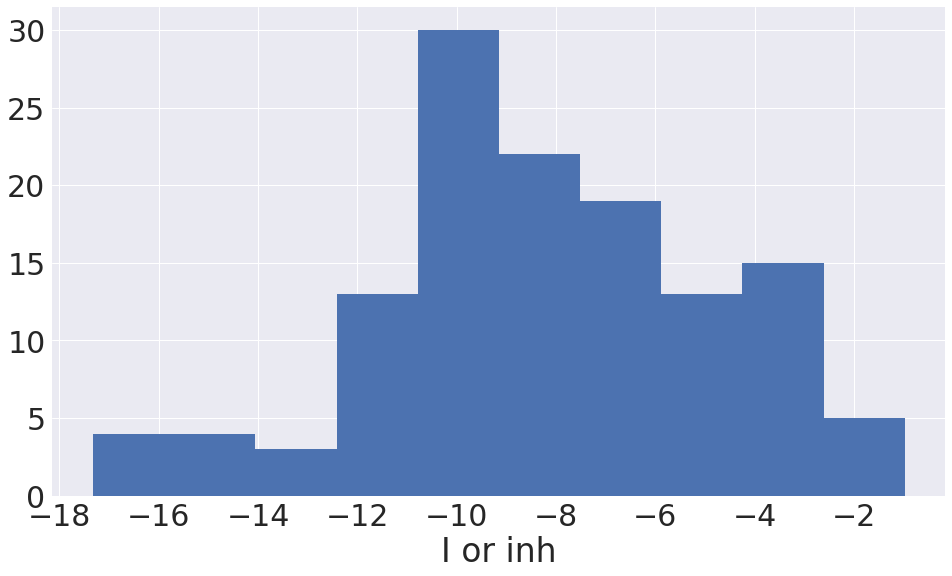

In [26]:
plt.hist(y_big_tau[:, 2])
plt.xlabel('I or inh')

In [27]:
index = 5
print(y_big_tau[index, :])
print(X_big_tau[index, :])

[ 0.58431499  7.95551157 -8.32051166]
[   0.43578216  118.05788855   -8.72439669]


Let's actually get the recall time for this values

In [46]:
index = 1


tau_z = 0.150



training_time = 0.100
inter_sequence_time = 1.000
dt = 0.001
epochs = 4
tau_z_post = 0.005
tau_w = 0.100


N = 10
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

G = 100.0
tau_m = 0.010
T = 1.0
I_cue = 0
I_end= 5

dt = 0.001

threshold = 0.5

tau_z = X_big_tau[index, 0]
max_w = X_big_tau[index, 1]
min_w = X_big_tau[index, 2]
T_cue = tau_z

pattern = 3
pattern_from = 2
recall_times = []
dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z,
                    tau_z_post, tau_w, epochs=epochs, max_w=max_w, min_w=min_w, save_w_history=False,
                    pre_rule=True)
    
w = dic['w']
dic = run_network_recall_limit_end(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, I_end, T_cue)
x_history = dic['x']

duration = get_recall_duration_for_pattern(x_history, pattern, dt)
recall_times.append(duration)

self = w[pattern, pattern]
exc = w[pattern, pattern_from]
inh = w[pattern_from, pattern]

print('self', self, 'exc', exc, 'inh', inh)
print('duration', duration)



self 0.213337164868 exc 3.37261049654 inh -3.70695179809
duration 0.03


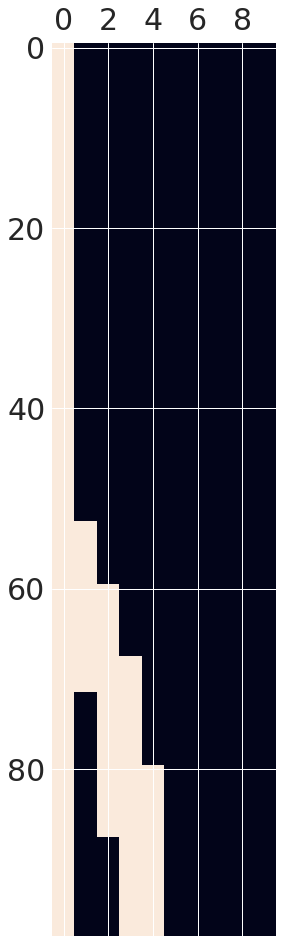

In [47]:
plt.matshow(x_history, aspect='auto')

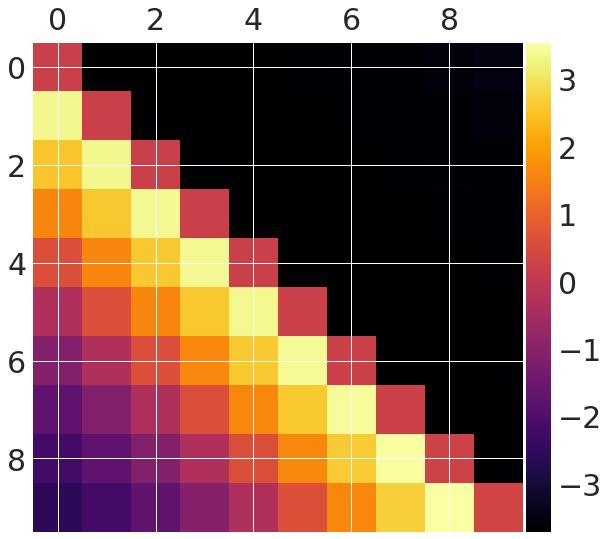

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)

norm = matplotlib.colors.Normalize(0, 2)
cmap = matplotlib.cm.inferno

im = ax.matshow(w, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax);

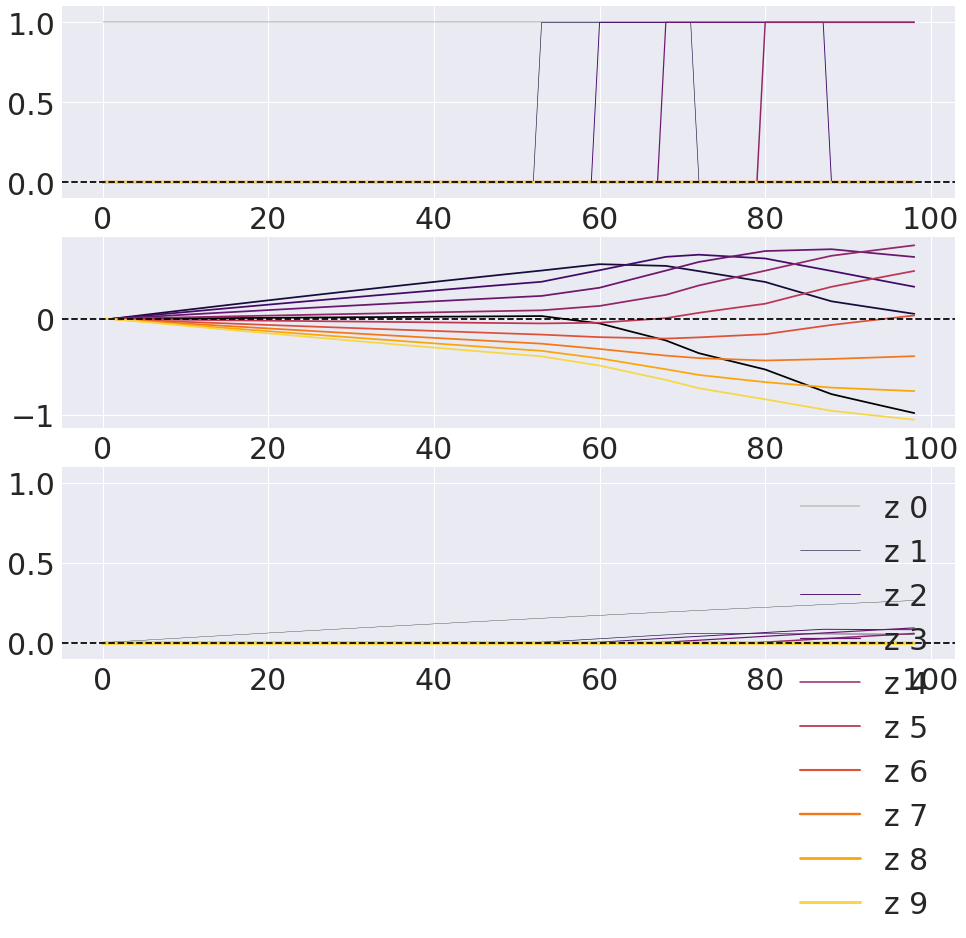

In [53]:
current_history = dic['current']
z_history = dic['z']

time = np.arange(0, T + dt, dt)

norm = matplotlib.colors.Normalize(0, N)
cmap = matplotlib.cm.inferno

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = sequences[0]
for pattern in patterns:
    width = pattern * 0.3 + 0.3
    ax1.plot(x_history[:, pattern], color=cmap(norm(pattern)),linewidth=width, label='x' + str(pattern))
    ax2.plot(current_history[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(z_history[:, pattern], color=cmap(norm(pattern)), linewidth=width, label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')
# ax1.legend();

ax1.set_ylim([-0.1, 1.1])
# ax2.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(0, ls='--', color='black')
# ax2.legend();

ax3.axhline(0, ls='--', color='black')
ax3.legend();


In [38]:
n_examples = X_big_tau.shape[0]
y_recalled = np.zeros_like(X_big_tau)

In [39]:
recall_times = np.zeros(n_examples)

for index in range(n_examples):



    training_time = 0.100
    inter_sequence_time = 1.000
    dt = 0.001
    epochs = 4
    tau_z_post = 0.005
    tau_w = 0.100


    N = 10
    sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

    G = 100.0
    tau_m = 0.010
    T = 20.0
    I_cue = 0
    I_end= 5

    dt = 0.001

    threshold = 0.5

    tau_z = X_big_tau[index, 0]
    max_w = X_big_tau[index, 1]
    min_w = X_big_tau[index, 2]
    T_cue = tau_z

    pattern = 3
    pattern_from = 2
    dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z,
                        tau_z_post, tau_w, epochs=epochs, max_w=max_w, min_w=min_w, save_w_history=False,
                        pre_rule=True)

    w = dic['w']
    dic = run_network_recall_limit_end(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, I_end, T_cue)
    x_history = dic['x']

    duration = get_recall_duration_for_pattern(x_history, pattern, dt)

    self = w[pattern, pattern]
    exc = w[pattern, pattern_from]
    inh = w[pattern_from, pattern]

    recall_times[index] = duration
    y_recalled[index, 0] = self
    y_recalled[index, 1] = exc
    y_recalled[index, 2] = inh
 

(array([ 83.,  32.,   9.,   1.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.001 ,  0.0039,  0.0068,  0.0097,  0.0126,  0.0155,  0.0184,
         0.0213,  0.0242,  0.0271,  0.03  ]),
 <a list of 10 Patch objects>)

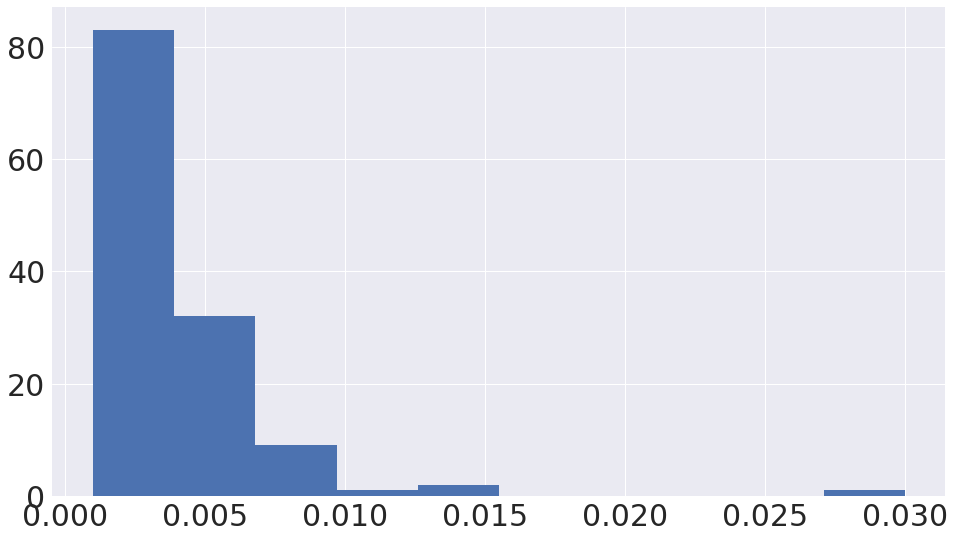

In [43]:
plt.hist(recall_times)

It is extremly small

In [45]:
np.where(recall_times > 0.020)[0]

array([1])